In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2

In [2]:
image_size = (512, 512)

test_subset_id = 9

output_folder = "output/"
work_data_folder = "data/"

detections_output_path = "output/detections"

image_folder_path = "../data/images"

for folder in [output_folder, work_data_folder, detections_output_path]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
def read_detection_result():
    detection_result_folder = "../output/valresults/caltech/h/off"

    detection_dfs = {}
    for epoch_id in tqdm(os.listdir(detection_result_folder), desc="test epoch"):
        current_folder_path = "{}/{}".format(detection_result_folder, epoch_id)

        detection_dfs.setdefault(epoch_id, {})
        for filename in os.listdir(current_folder_path):
            series_id = filename[0:-4]
            file = os.path.join(current_folder_path, filename)
            result_df = pd.read_csv(file, delimiter=" ", header=None)
            result_df.columns = ["z-index", "top_left_x", "top_left_y", "width", "height", "possibility"]
            detection_dfs.get(epoch_id).setdefault(series_id, result_df)

    return detection_dfs

In [4]:
test_detections = read_detection_result()
# test_detections["001"]

test epoch: 100%|██████████| 58/58 [00:06<00:00,  9.27it/s]


In [5]:
def world_to_voxel_coord(world_coord, origin, spacing):
    stretched_voxel_coord = np.absolute(world_coord - origin)
    voxel_coord = stretched_voxel_coord / spacing
    return voxel_coord


def read_ground_truth_data():
    fid = open("../data/cache/test", 'rb')
    test_pickle = pickle.Unpickler(fid, encoding="latin1")
    test_cache = test_pickle.load()

    gt_df = pd.DataFrame(test_cache)
    gt_df["series_id"] = gt_df["filepath"].map(lambda x: x.split("/")[-2])
    gt_df["z-index"] = gt_df["filepath"].map(lambda x: int(x.split("/")[-1][2:-4]))

    return gt_df

In [6]:
annotations = read_ground_truth_data()
annotations.head()

,bboxes,ignoreareas,filepath,series_id,z-index
0,"[[342, 267, 366, 291]]",[],data/images/1.3.6.1.4.1.14519.5.2.1.6279.6001....,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,121
1,"[[227, 302, 235, 309]]",[],data/images/1.3.6.1.4.1.14519.5.2.1.6279.6001....,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,57
2,"[[87, 225, 92, 231]]",[],data/images/1.3.6.1.4.1.14519.5.2.1.6279.6001....,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,64
3,"[[387, 281, 399, 292]]",[],data/images/1.3.6.1.4.1.14519.5.2.1.6279.6001....,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,69
4,"[[127, 230, 134, 237]]",[],data/images/1.3.6.1.4.1.14519.5.2.1.6279.6001....,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,82


In [7]:
def compute_overlap_area_ratio(a, b):
    a_top_left_x, a_top_left_y, a_bottom_right_x, a_bottom_right_y = a
    b_top_left_x, b_top_left_y, b_bottom_right_x, b_bottom_right_y = b

    overlap_width = min(a_bottom_right_x, b_bottom_right_x) - max(a_top_left_x, b_top_left_x)
    if overlap_width <= 0:
        return 0

    overlap_height = min(a_bottom_right_y, b_bottom_right_y) - max(a_top_left_y, b_top_left_y)
    if overlap_height <= 0:
        return 0

    a_area = (a_bottom_right_x - a_top_left_x) * (a_bottom_right_y - a_top_left_y)
    b_area = (b_bottom_right_x - b_top_left_x) * (b_bottom_right_y - b_top_left_y)

    overlap_area = overlap_width * overlap_height
    total_area = a_area + b_area - overlap_area

    overlap_ratio = overlap_area / total_area
    return overlap_ratio

In [8]:
def calculate_mr_50(threshold = 0.5):
    for epoch_id in tqdm(test_detections.keys(), desc="epoch"):
        epoch_test_result = test_detections[epoch_id]

        hit_counter = 0

        number_of_test = 0

        for series_id in epoch_test_result.keys():
            image_detections = epoch_test_result[series_id]
            image_detections["z-index"] = image_detections["z-index"].map(lambda x: round(x))
            image_detections["bottom_right_x"] = image_detections["top_left_x"] + image_detections["height"]
            image_detections["bottom_right_y"] = image_detections["top_left_y"] + image_detections["height"]
            image_detections["bbox"] =  list(image_detections[['top_left_x', 'top_left_y', "bottom_right_x", "bottom_right_y"]].to_records(index=False))

            nodules = annotations[annotations["series_id"] == series_id]

            for i, nodule in nodules.iterrows():
                z_index = nodule["z-index"]

                detections = image_detections[image_detections['z-index'] == z_index].reset_index()
                matched_detection = set()

                nodule_id = 0
                for bbox in nodule["bboxes"]:
                    max_ratio = threshold
                    best_detection_id = -1
                    number_of_test += 1

                    for detection_id, detection in detections.iterrows():
                        if detection_id in matched_detection:
                            continue

                        ratio = compute_overlap_area_ratio(bbox, detection["bbox"])

                        if ratio > max_ratio:
                            best_detection_id = detection_id
                            max_ratio = ratio

                    if best_detection_id != -1:
                        hit_counter += 1
                        matched_detection.add(best_detection_id)
                        best_detection = detections.iloc[best_detection_id]

                        image = cv2.imread("{}/{}/z-{}.jpg".format(image_folder_path, series_id, z_index))

                        # add red detection rect
                        image = cv2.rectangle(image, (round(best_detection["top_left_x"]), round(best_detection["top_left_y"])), (round(best_detection["bottom_right_x"]), round(best_detection["bottom_right_y"])), (0, 0, 255), 1)

                        # add green annotation rect
                        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)

                        folder = "{}/{}".format(detections_output_path, epoch_id)
                        if not os.path.exists(folder):
                            os.makedirs(folder)

                        cv2.imwrite("{}/{}-z{}-nodule{}-{}.jpg".format(folder, series_id, z_index, nodule_id, max_ratio), image)

                nodule_id += 1

        hit_rate = hit_counter / number_of_test
        miss_rate_y.append(1 - hit_rate)
        miss_rate_x.append(epoch_id)

In [9]:
miss_rate_x = []
miss_rate_y = []

calculate_mr_50(threshold=0.5)



epoch: 100%|██████████| 58/58 [00:55<00:00,  1.05it/s]


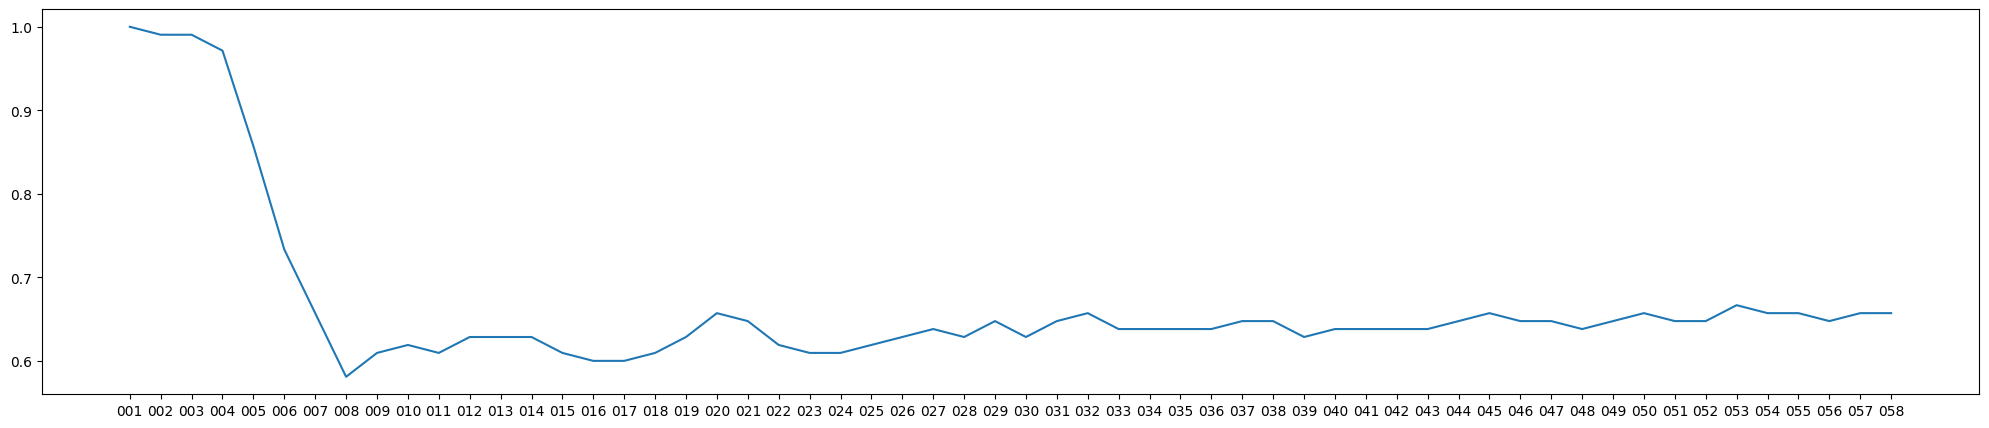

In [33]:
figure(figsize=(25, 5))
plt.plot(miss_rate_x, miss_rate_y, label='MR')

In [34]:
list(zip(miss_rate_x, miss_rate_y))

[('001', 1.0),
 ('002', 0.9904761904761905),
 ('003', 0.9904761904761905),
 ('004', 0.9714285714285714),
 ('005', 0.8571428571428572),
 ('006', 0.7333333333333334),
 ('007', 0.6571428571428571),
 ('008', 0.5809523809523809),
 ('009', 0.6095238095238096),
 ('010', 0.6190476190476191),
 ('011', 0.6095238095238096),
 ('012', 0.6285714285714286),
 ('013', 0.6285714285714286),
 ('014', 0.6285714285714286),
 ('015', 0.6095238095238096),
 ('016', 0.6),
 ('017', 0.6),
 ('018', 0.6095238095238096),
 ('019', 0.6285714285714286),
 ('020', 0.6571428571428571),
 ('021', 0.6476190476190475),
 ('022', 0.6190476190476191),
 ('023', 0.6095238095238096),
 ('024', 0.6095238095238096),
 ('025', 0.6190476190476191),
 ('026', 0.6285714285714286),
 ('027', 0.638095238095238),
 ('028', 0.6285714285714286),
 ('029', 0.6476190476190475),
 ('030', 0.6285714285714286),
 ('031', 0.6476190476190475),
 ('032', 0.6571428571428571),
 ('033', 0.638095238095238),
 ('034', 0.638095238095238),
 ('035', 0.638095238095238),